In [4]:
from collections import deque

import ale_py
import cv2
import gymnasium as gym
import numpy as np
import zarr
import random

gym.register_envs(ale_py)
TOTAL_FRAMES = 50_000

In [5]:
def preprocess(rgb):
    return (
        cv2.resize(rgb, (84, 84), interpolation=cv2.INTER_AREA)
        .transpose(2, 0, 1)
        .astype(np.uint8)
    )

In [6]:
root = zarr.open_group(store="dataset50k.zarr")
compressors = zarr.codecs.BloscCodec(
    cname="zstd", clevel=1, shuffle=zarr.codecs.BloscShuffle.bitshuffle
)

GAMES = [
    "ALE/SpaceInvaders-v5",
    "ALE/Krull-v5",
    "ALE/BeamRider-v5",
    "ALE/Hero-v5",
    "ALE/StarGunner-v5",
    "ALE/MsPacman-v5",
]


for game in GAMES:
    game_dataset = root.create_group(
        name=game.split("/")[-1].replace("-v5", "")
    )

    frames = game_dataset.create_array(
        name="frames",
        shape=(TOTAL_FRAMES, 4, 3, 84, 84),
        chunks=(32, 4, 3, 84, 84),  # 2.7 MB raw
        shards=(4096, 4, 3, 84, 84),  # ≈115 MB compressed
        dtype=np.uint8,
        compressors=compressors,
        overwrite=True,
    )

    actions = game_dataset.create_array(
        name="actions",
        shape=(TOTAL_FRAMES,),
        chunks=(32,),
        shards=(4096,),
        dtype=np.uint8,
        compressors=compressors,
        overwrite=True,
    )

    rewards = game_dataset.create_array(
        name="rewards",
        shape=(TOTAL_FRAMES,),
        chunks=(32,),
        shards=(4096,),
        dtype=np.float32,
        compressors=compressors,
        overwrite=True,
    )

    dones = game_dataset.create_array(
        name="dones",
        shape=(TOTAL_FRAMES,),
        chunks=(32,),
        shards=(4096,),
        dtype=np.bool_,
        compressors=compressors,
        overwrite=True,
    )

    frames_np = np.empty((TOTAL_FRAMES, 4, 3, 84, 84), dtype=np.uint8)
    actions_np = np.empty((TOTAL_FRAMES,), dtype=np.uint8)
    rewards_np = np.empty((TOTAL_FRAMES,), dtype=np.float32)
    dones_np = np.empty((TOTAL_FRAMES,), dtype=np.bool_)

    env = gym.make(game, frameskip=1)
    obs, _ = env.reset(seed=0)

    stack = deque([preprocess(obs)] * 4, maxlen=4)  # Initialize with 4 frames

    i = 0
    while i < TOTAL_FRAMES:
        cumulative_reward = 0.0
        terminated = False
        truncated = False

        action = env.action_space.sample()
        for _ in range(4):  # repeat 4 frames for one action
            obs, reward, terminated, truncated, _ = env.step(action)
            cumulative_reward += reward
            stack.append(preprocess(obs))

            if terminated or truncated:
                break

        if len(stack) < 4:
            obs, _ = env.reset()
            stack = deque([preprocess(obs)] * 4, maxlen=4)
            continue  # discard partial stack

        frames_np[i] = np.stack(stack, axis=0)
        actions_np[i] = action
        rewards_np[i] = cumulative_reward
        dones_np[i] = terminated or truncated
        i += 1

        if terminated or truncated:
            obs, _ = env.reset()
            stack = deque([preprocess(obs)] * 4, maxlen=4)

        print(
            f"Collected {i}/{TOTAL_FRAMES} frames for {game.split('/')[-1]}",
            end="\r",
        )

    frames[:] = frames_np
    actions[:] = actions_np
    rewards[:] = rewards_np
    dones[:] = dones_np

    env.close()

In [16]:
import zarr, numpy as np

root = zarr.open_group("dataset50k.zarr", mode="r")
reward = root["Hero/rewards"][:]

In [17]:
# number of non-zero rewards
reward_nonzero = reward[reward != 0]
print(f"Number of non-zero rewards: {len(reward_nonzero)}")

# ratio of non-zero rewards
reward_ratio = len(reward_nonzero) / len(reward)
print(f"Ratio of non-zero rewards: {reward_ratio:.2%}")

Number of non-zero rewards: 781
Ratio of non-zero rewards: 1.56%


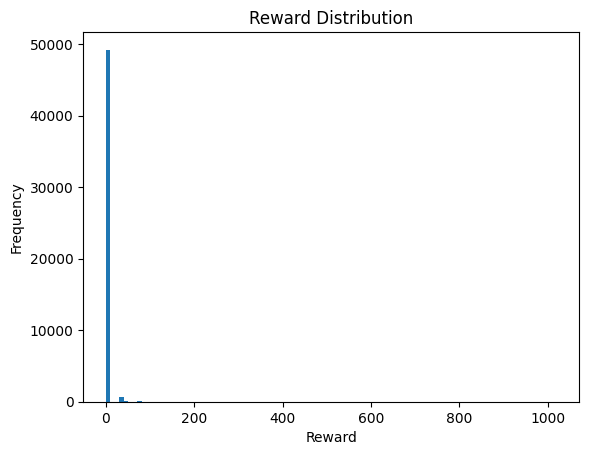

In [18]:
np.histogram(reward, bins=100)
import matplotlib.pyplot as plt

plt.hist(reward, bins=100)
plt.title("Reward Distribution")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.show()